In [44]:
import time
import numpy as np
import cvxpy as cp
import os.path as op

import importlib

from copy import deepcopy

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import h5py

import nibabel as nib

import sys
sys.path.append("../")

from src import node_list
from src import nilearn_viz
from src import power_crtl
from src import pkl_custom
from src import plot_stat_on_surf

import networkx as nx

In [45]:
root_path = "../"
data_path = "/Users/mikichan/Desktop/mywork/atlas_data/"

In [46]:
scale = 1
connFilename = op.join(data_path, f'fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5')

hf = h5py.File(connFilename, 'r')
centers = np.array(hf.get('header').get('gmcoords'))
gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]
hf.close()

roi_path = op.join(data_path, 'fiber_atlas/gmlabels_vol.nii')
roi_atlas = nib.load(roi_path)

## Power Control - Testing behaviour and convergence
- Weighting
- Noise level variation
- Random state variation

In [47]:
adj = pkl_custom.open_pkl_file(op.join(root_path, './resources/lausanne2018-info.pkl'))['adjacency']
graph = nx.from_numpy_array(adj)
assert nx.is_connected(graph)

In [56]:
importlib.reload(power_crtl)
solver = power_crtl.PowerControl(deepcopy(adj), rand_p=True, seed_p=0)
solver_updated = power_crtl.PowerControl_updated(deepcopy(adj), rand_p=True, 
                                                 seed_p=0, nodes_weight=np.ones(adj.shape[0]))

tmp1 = solver.run()
tmp2 = solver_updated.optimize()

np.testing.assert_almost_equal(tmp1, tmp2)

In [78]:
solutions = []
for seed_k in tqdm(np.arange(1000)):
    solver = power_crtl.PowerControl(adj, rand_p=True, seed_p=seed_k)
    solutions.append(solver.run())
solutions = np.array(solutions)

100%|██████████| 1000/1000 [00:20<00:00, 48.00it/s]


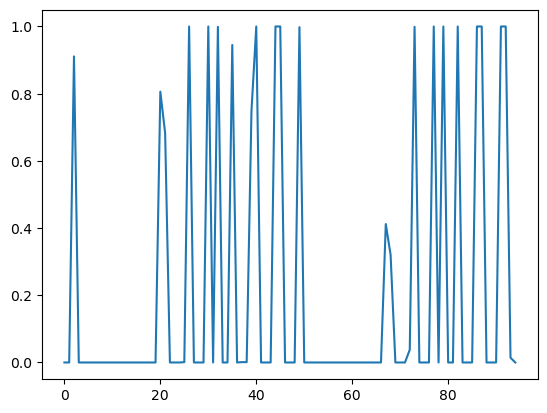

In [90]:
mean_distribution = solutions.mean(axis=0)
plt.plot(mean_distribution)

(<Figure size 2000x1500 with 8 Axes>,
 array([[<Axes3D: >, <Axes3D: >],
        [<Axes3D: >, <Axes3D: >]], dtype=object))

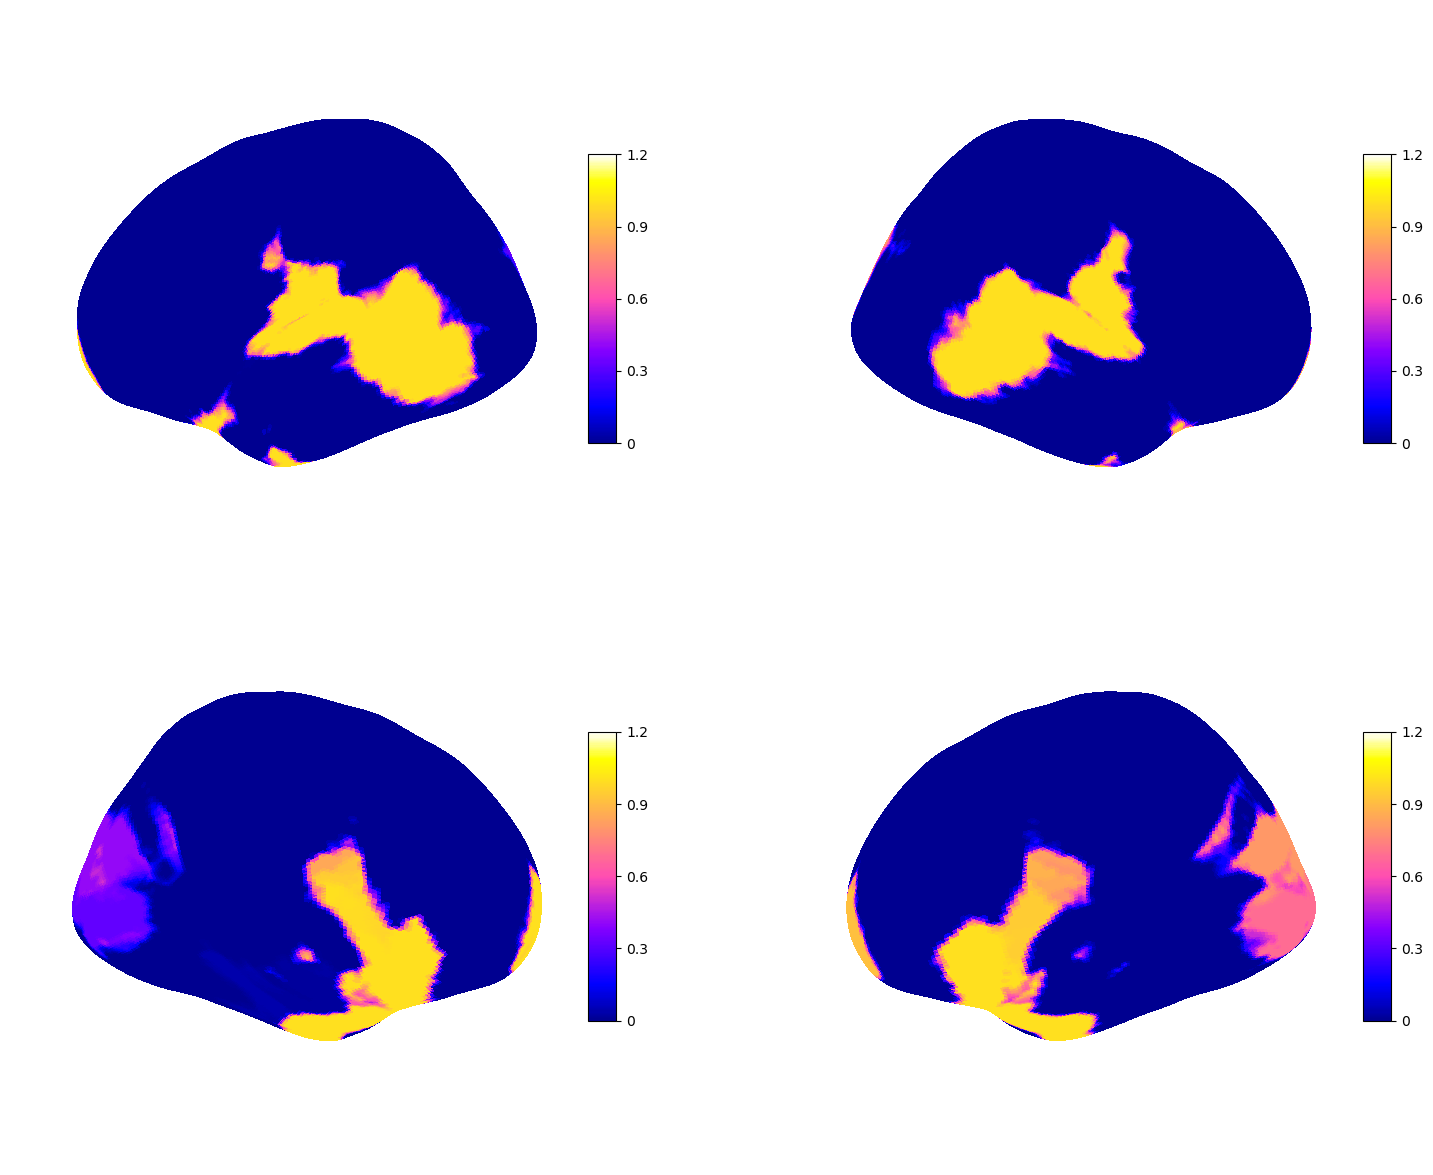

In [92]:
plot_stat_on_surf.plot_node_signal_on_surf(even_distribution(mean_distribution, factor=1),
                                           roi_path, gmregions_names, vmin=-0.2, vmax=1.2, cmap='gnuplot2')